#### Losing customers is not good, and if you can predict when a customer will stop using the service, you will have an opportunity to make decisions to retain the customer. Our goal in this article is create and compare Churn Prediction Machine Learning models.

##### This article use the Telco Churn Customer Dataset, available on Kaggle.

In [1]:
# import required libraries
import numpy as np
import pandas as pd

import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# laod data
path = './data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


##### We can see some informations about the dataset with the function pandas.DataFrame.info(). This function gives us the overall information about the DataFrame like all the columns, the type os columns and the number of non-null values of the columns.

##### We don’t need to handle missing values and we just have a few numerical features. In this dataset we already have the label we want to predict, the Churn column, but if it’s not included we need to create it based on its definition. If the definition is not available is necessary to define it before labelling.
##### The dataset refers to a Telecommunication company. There is information about customers, like Partner, Dependents, etc, and about their contracts, like PhoneService, MonthlyCharges, etc. Some features show how long the customer have been using the service, such as tenure and TotalCharges, respectively, mean/represents time in months that the customer has the service and total amount paid by the customer.

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64


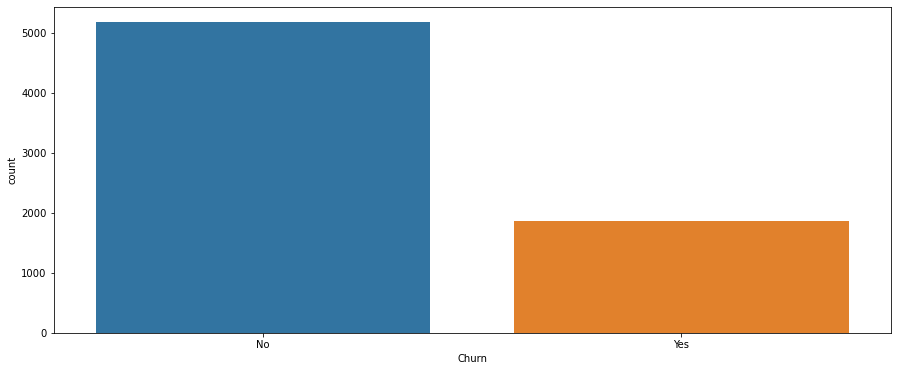

In [4]:
# Let's see the churn distribution with seaborn library
print(df['Churn'].value_counts(normalize=True))

fig, ax = plt.subplots(figsize=(15,6))
sns.countplot(data=df, x='Churn', ax=ax)

plt.show()

#### Using LabelEncoder to convert Churn data to Binary 0,1

In [5]:
text_label = LabelEncoder()
df['Churn'] = text_label.fit_transform(df['Churn'])
df['Churn']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int32

In [6]:
# df['Churn'] = pd.get_dummies(data=df['Churn'])
# df['Churn']

#### Now we need to convert columns that have Yes, No, No Service into Yes and No values.

In [7]:
print(df['MultipleLines'].value_counts())

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64


In [8]:
#df['OnlineBackup'].apply(lambda x: x.split()[0])
df['OnlineBackup'].value_counts()

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

In [9]:
print(df['MultipleLines'][0].split()[0])

No


In [10]:
df['MultipleLines'] = df['MultipleLines'].apply(lambda x: x.split()[0])
df['OnlineBackup'] = df['OnlineBackup'].apply(lambda x: x.split()[0])
df['OnlineSecurity'] = df['OnlineSecurity'].apply(lambda x: x.split()[0])
df['DeviceProtection'] = df['DeviceProtection'].apply(lambda x: x.split()[0])
df['TechSupport'] = df['TechSupport'].apply(lambda x: x.split()[0])
df['StreamingMovies'] = df['StreamingMovies'].apply(lambda x: x.split()[0])
df['StreamingTV'] = df['StreamingTV'].apply(lambda x: x.split()[0])

In [11]:
df['MultipleLines'].value_counts()

No     4072
Yes    2971
Name: MultipleLines, dtype: int64

In [12]:
df['TechSupport'].value_counts()

No     4999
Yes    2044
Name: TechSupport, dtype: int64

In [13]:
# Defining functions that take a graph/chart and adds normalized value_counts into them.
# one for countplot and one for barplot
def countplot_add_value_counts(g):
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{:1.4f}'.format(100*height/len(df)),
            ha="center", color='white')
        
        
def barplot_add_value_counts(g):
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{:1.4f}'.format(100*height),
            ha="center", color='white')    

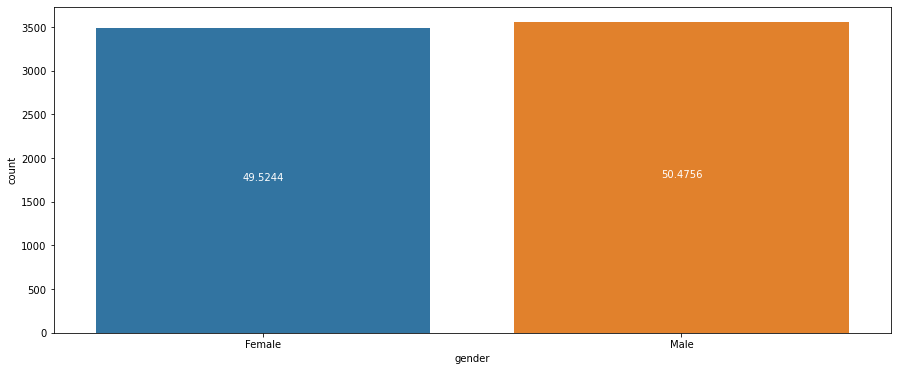

In [14]:
# Let's see the gender distribution with seaborn library
#print(df['gender'].value_counts(normalize=True))

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(data=df, x='gender', ax=ax)
countplot_add_value_counts(g)
plt.show()

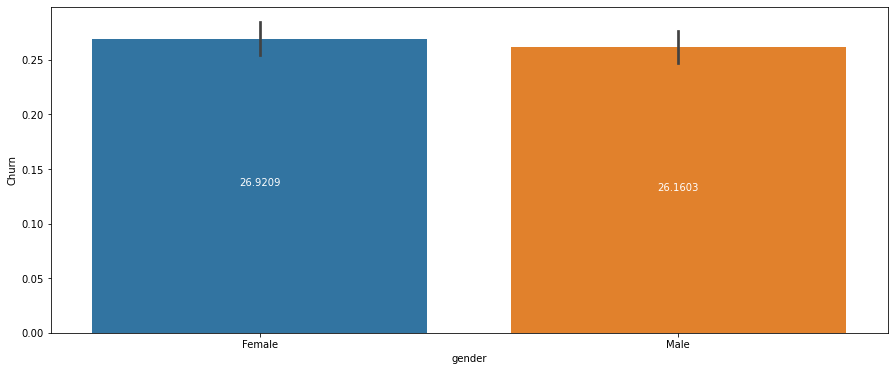

In [15]:
# Let's see the gender distribution for churn users with seaborn library
#print(df[df['Churn']==1]['gender'].value_counts(normalize=True))


fig, ax = plt.subplots(figsize=(15,6))
g = sns.barplot(x=df['gender'], y=df['Churn'], ax=ax)
barplot_add_value_counts(g)
plt.show()

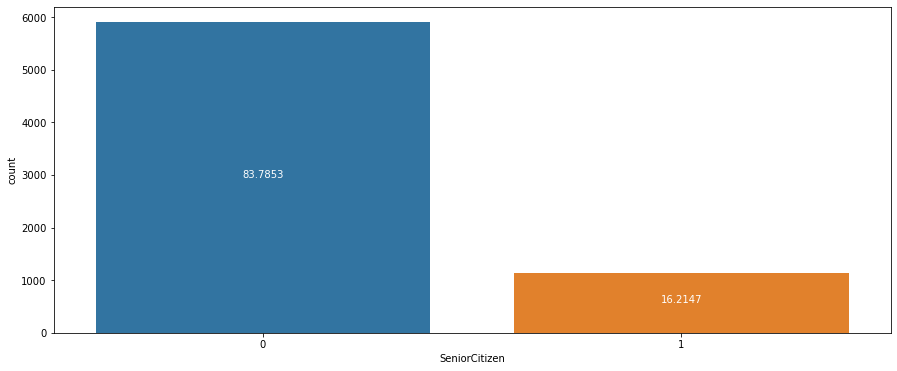

In [16]:
# Let's see the distribution of Senior Citizens
#print(df['SeniorCitizen'].value_counts(normalize=True))


fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(data=df, x='SeniorCitizen', ax=ax)
countplot_add_value_counts(g)
plt.show()

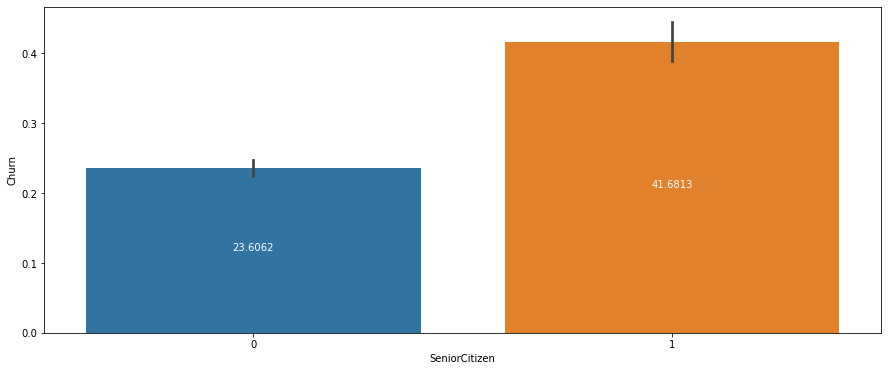

In [17]:
# Let's see the Senior Citizens distribution for churn users with seaborn library
#print(df[df['Churn']==1]['SeniorCitizen'].value_counts(normalize=True))

fig, ax = plt.subplots(figsize=(15, 6))
g = sns.barplot(y='Churn', x='SeniorCitizen', data=df, ax=ax)
barplot_add_value_counts(g)
plt.show()

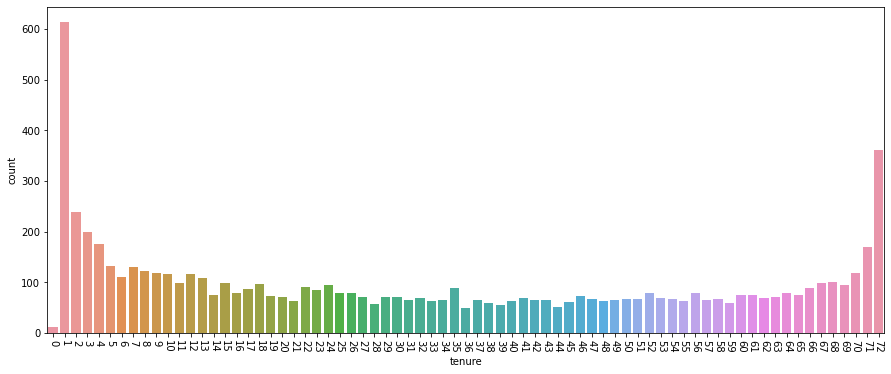

In [18]:
# Let's see the distribution of tenure
#print(df['tenure'].value_counts(normalize=True))

fig, ax = plt.subplots(figsize=(15, 6))
g = sns.countplot(df['tenure'], ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=-90)
plt.show()

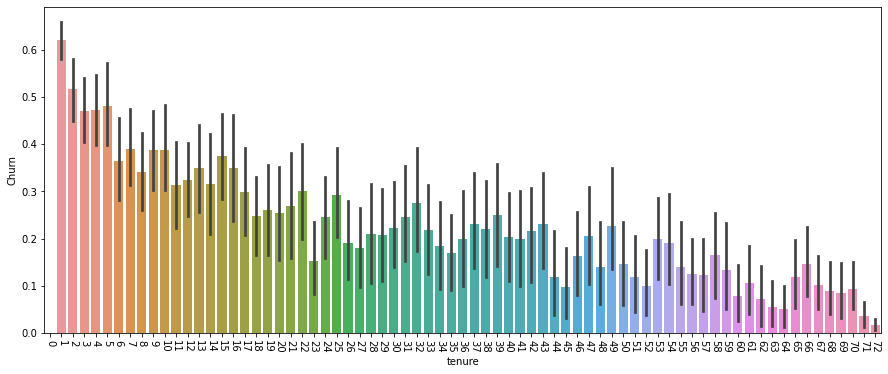

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.barplot(df['tenure'], df['Churn'], ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=-90)
plt.show()

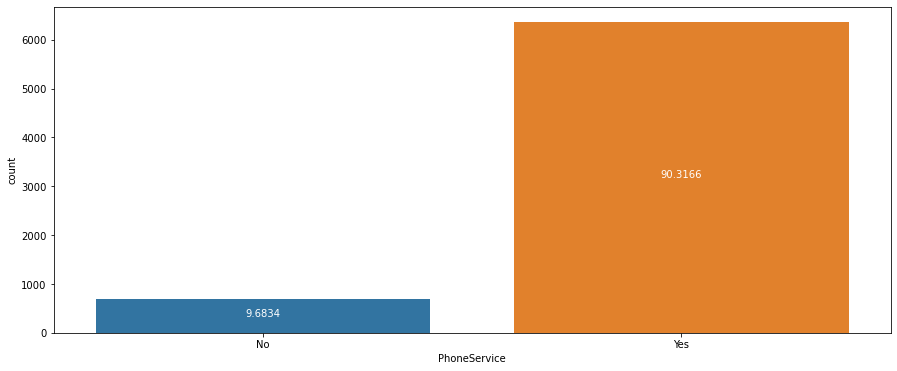

In [20]:
# Let's see the distribution of Phone Service
#print(df['PhoneService'].value_counts(normalize=True))

fig, ax = plt.subplots(figsize=(15, 6))
g = sns.countplot(data=df, x='PhoneService', ax=ax)
countplot_add_value_counts(g)
plt.show()

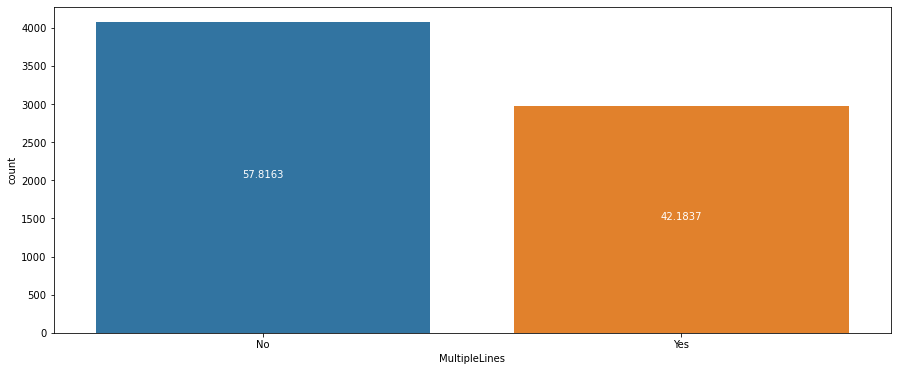

In [21]:
# Let's see the distribution of Multiple Lines of Service
#print(df['MultipleLines'].value_counts(normalize=True))

fig, ax = plt.subplots(figsize=(15, 6))
g = sns.countplot(data=df, x='MultipleLines', ax=ax)
countplot_add_value_counts(g)
plt.show()

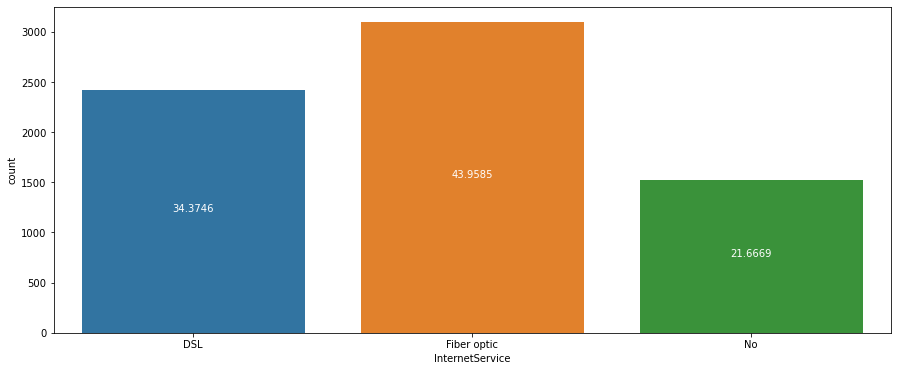

In [22]:
# Let's see the distribution of Internet Service
#print(df['InternetService'].value_counts(normalize=True))

fig, ax = plt.subplots(figsize=(15, 6))
g = sns.countplot(data=df, x='InternetService', ax=ax)
countplot_add_value_counts(g)
plt.show()

In [23]:
# Let's see the distribution of Online Security
#print(df['OnlineSecurity'].value_counts(normalize=True))


# fig, ax = plt.subplots(figsize=(15, 6))
# g = sns.countplot(data=df, x='OnlineSecurity', ax=ax)
# for p in g.patches:
#     height = p.get_height()
#     g.text(p.get_x()+p.get_width()/2.,
#             height/2,
#             '{:1.4f}'.format(100*height/len(df)),
#             ha="center", color='white')
# plt.show()

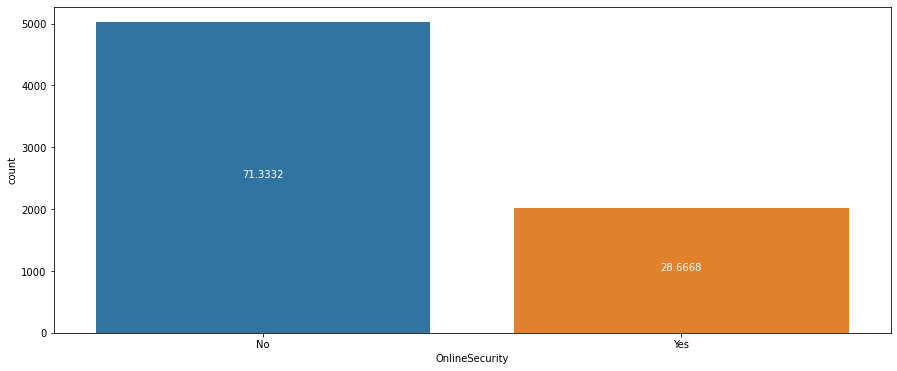

In [24]:
# Let's see the distribution of Online Security
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.countplot(data=df, x='OnlineSecurity', ax=ax)
countplot_add_value_counts(g)
plt.show()

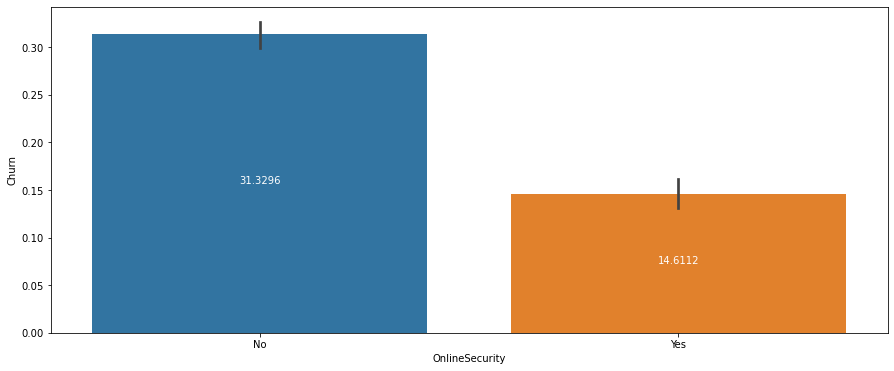

In [28]:
# Churn rate comparison with Online security service
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.barplot(y='Churn', data=df, x='OnlineSecurity', ax=ax)
barplot_add_value_counts(g)
plt.show()

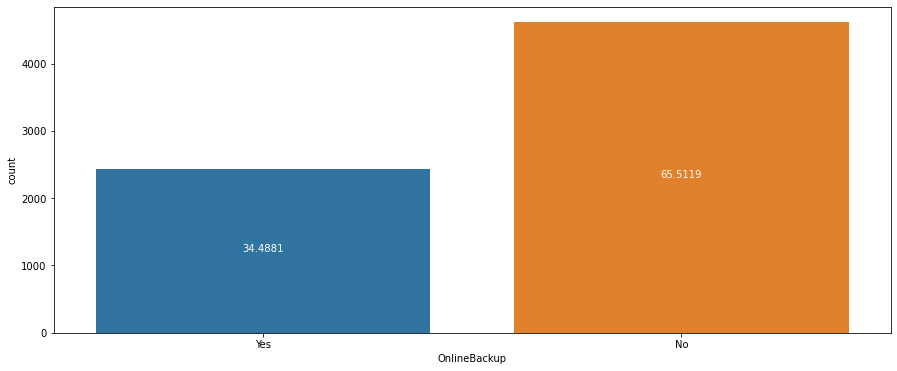

In [25]:
# Let's see the distribution of Online backup
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.countplot(data=df, x='OnlineBackup', ax=ax)
countplot_add_value_counts(g)
plt.show()

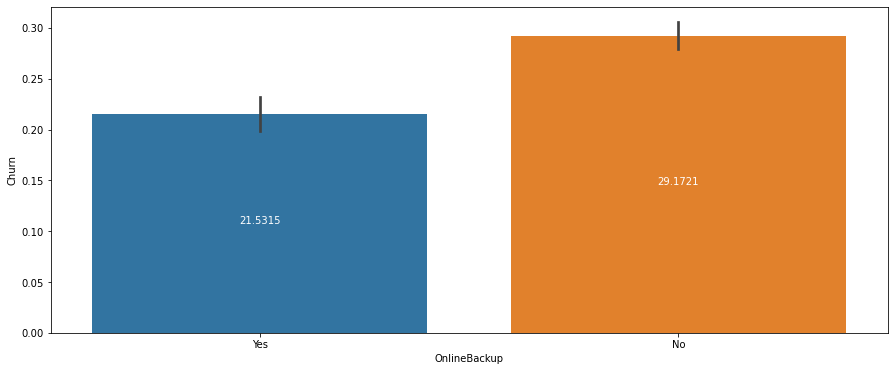

In [26]:
# Churn rate comparison with Online Backup service
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.barplot(y='Churn', data=df, x='OnlineBackup', ax=ax)
barplot_add_value_counts(g)
plt.show()

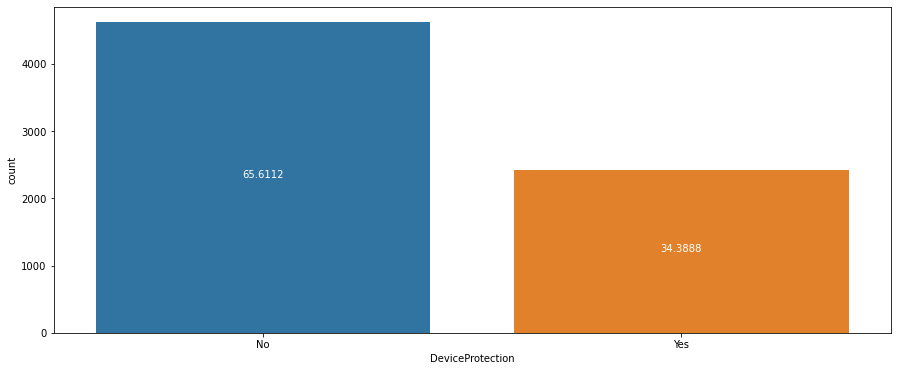

In [29]:
# Let's see the distribution of Device Protection
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.countplot(data=df, x='DeviceProtection', ax=ax)
countplot_add_value_counts(g)
plt.show()

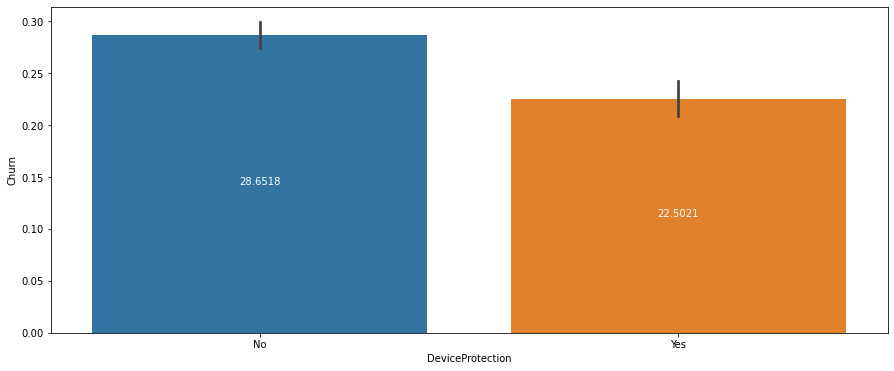

In [30]:
# Churn rate comparison with Device Protection service
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.barplot(y='Churn', data=df, x='DeviceProtection', ax=ax)
barplot_add_value_counts(g)
plt.show()

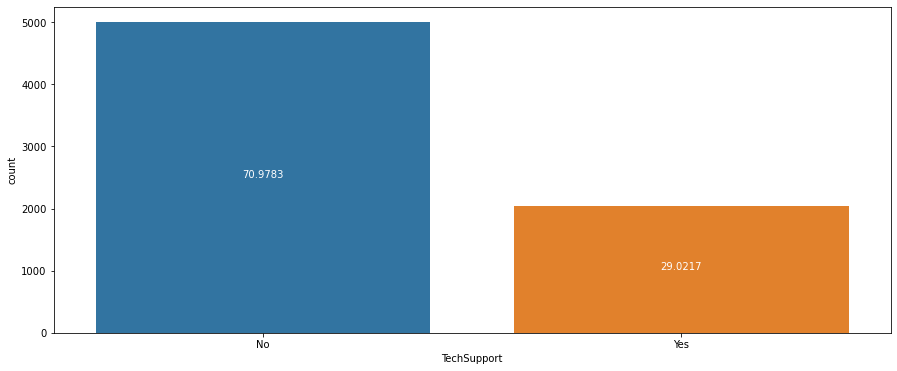

In [31]:
# Let's see the distribution of TechSupport
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.countplot(data=df, x='TechSupport', ax=ax)
countplot_add_value_counts(g)
plt.show()

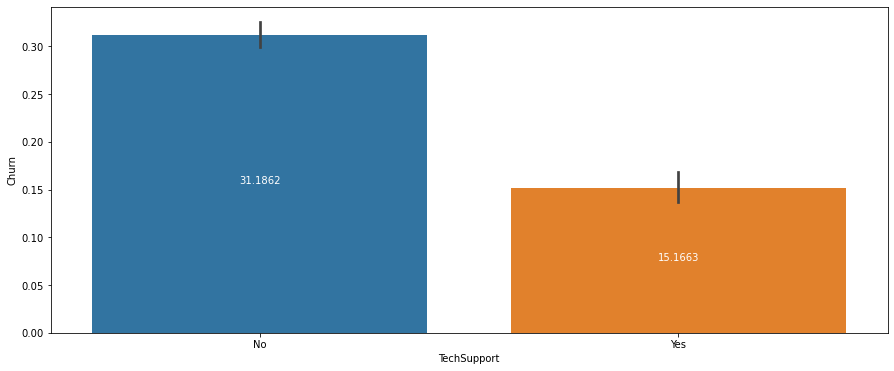

In [32]:
# Churn rate comparison with TechSupport service
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.barplot(y='Churn', data=df, x='TechSupport', ax=ax)
barplot_add_value_counts(g)
plt.show()

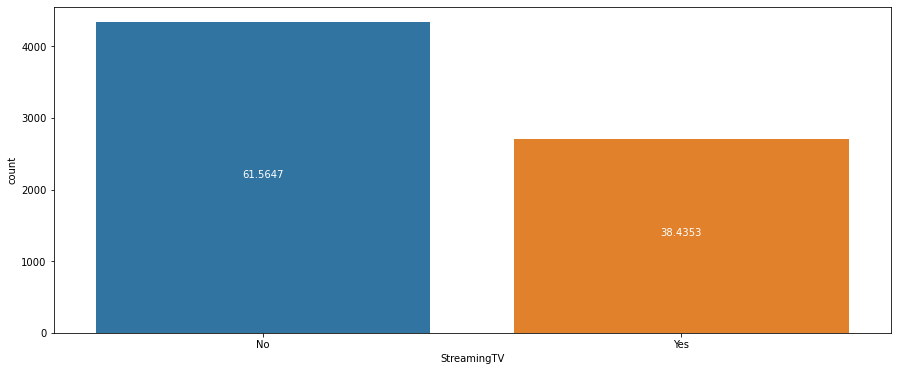

In [33]:
# Let's see the distribution of StreamingTV
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.countplot(data=df, x='StreamingTV', ax=ax)
countplot_add_value_counts(g)
plt.show()

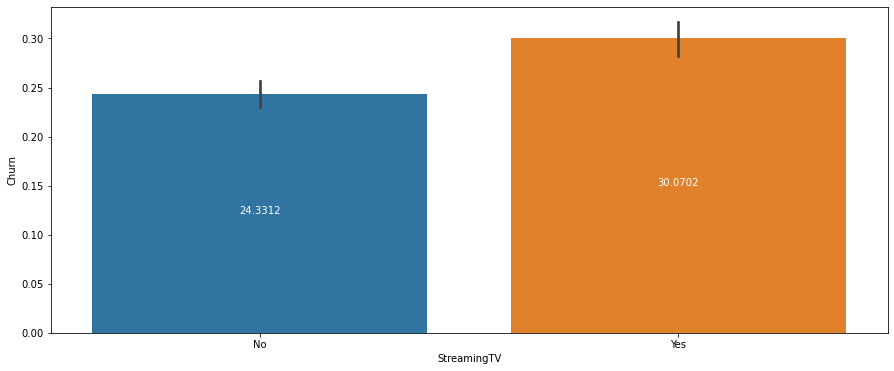

In [34]:
# Churn rate comparison with StreamingTV service
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.barplot(y='Churn', data=df, x='StreamingTV', ax=ax)
barplot_add_value_counts(g)
plt.show()